In [155]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For this stage, we will fit 2 models to use as benchmark models:

* **First model**: We will fit a linear regression with all the features, only performing a standard scaling.
* **Second model**: we will perform a power transformation to obtain gaussian variables and then proceed with a feature selection to identify the ost relevant variables

For both models, we will use the iterative imputer provided by scikit-learn to fill NaN's that are present.

In [157]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    f_regression,
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler


from urbana.features import normaltests
from urbana.constants import DIR_REPO, DIR_DATA, RANDOM_STATE
from urbana.models.plot_predictions import PredictedAccuracy
from urbana.features.selection import KBestSelector

from pathlib import Path

DATA_PATH = Path("../data")

SCL_DATA_PATH = DATA_PATH / "raw" / "scl"
PATH_CENSUS = SCL_DATA_PATH / "census"

INTERIM_CL = DATA_PATH / "interim" / "scl"

EXTERNAL_CL = DATA_PATH / "external" / "scl"
PATH_URBAN_AREAS = EXTERNAL_CL / "urban_areas"
PATH_R13 = EXTERNAL_CL / "R13"

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [158]:
SAVE_FIGS = True
SAVE_MODEL = True

VARIABLE_TO_PREDICT = "Airbnb_Count"
PROCESSED_PATH = DATA_PATH / "processed" / "scl"

DIR_VAR = PROCESSED_PATH / "{}".format(VARIABLE_TO_PREDICT)
DIR_LINEAR = DIR_VAR / "01_linear"

if SAVE_FIGS is True or SAVE_MODEL is True:
    folder_list = [DIR_VAR, DIR_LINEAR]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [159]:
PATH_TO_FILE = INTERIM_CL / "census_processed.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "11_census_acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

# Target variable

In [160]:
np.random.seed(RANDOM_STATE)

sect = pd.read_csv(PATH_TO_FILE).fillna(0)

sect = sect.loc[:, ~sect.columns.str.contains("^Unnamed")]

# sect["Tag"] = sect.apply(lambda x: print(x))
# sect["Tag"] = sect.apply(lambda x: x["REGION"] + x["PROVINCIA"] + x["COMUNA"] + x["COD_DISTRI"], axis=1)
# sect["Tag"].value_counts()

# sect.set_index("Tag", inplace=True)

sect.drop(
    [
        "REGION",
        "PROVINCIA",
        "COMUNA",
        "COD_DISTRI",
        "DESC_REGIO",
        "DESC_PROVI",
        "DESC_COMUN",
        "DESC_DISTR",
    ],
    axis=1,
    inplace=True,
)
sect.sample(5)

,geometry,INMIGRANTES,PUEBLO_ORIGINARIO_INDIGENA,VIVIENDAS_PARTITUCLARES,VIVIENDAS_COLECTIVAS,POBLACION,MUJERES_%,HOMBRES_%,EDAD_0A5_%,EDAD_6A14_%,...,bank_pois_count,healthcare_pois_count,food_pois_count,education_pois_count,pharmacy_pois_count,artwork_pois_count,Airbnb_Count,Airbnb_Price,Airbnb_Per_Person_Price,Airbnb_Location_Rating
237,POLYGON ((-70.66766516499996 -33.4707052149999...,1068,668,2807,4,8246.0,0.518069,0.481931,0.064637,0.081130,...,0.0,0.0,5.0,2.0,0.0,0.0,14.0,31357.142857,15910.714286,4.460
116,POLYGON ((-70.56655512499998 -33.5503908179999...,742,3065,8939,3,28022.0,0.520413,0.479587,0.071444,0.107772,...,0.0,0.0,2.0,11.0,0.0,0.0,1.0,30000.000000,15000.000000,0.000
113,POLYGON ((-70.60760155299994 -33.5414271609999...,411,1391,3618,3,11973.0,0.505387,0.494613,0.071077,0.100643,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.000000,0.000000,0.000
42,MULTIPOLYGON (((-70.73751118497233 -33.3725643...,3004,3480,11951,0,38470.0,0.507148,0.492852,0.086561,0.130439,...,0.0,2.0,13.0,2.0,8.0,0.0,6.0,45198.000000,17572.134259,4.845
126,POLYGON ((-70.60981666499998 -33.5260787669999...,747,1555,3752,4,11892.0,0.499411,0.500589,0.073495,0.103010,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.000000,0.000


In [161]:
y = sect[VARIABLE_TO_PREDICT]

from sklearn import preprocessing

airbnb_variables = [
    "Airbnb_Count",
    "Airbnb_Price",
    "Airbnb_Per_Person_Price",
    "Airbnb_Location_Rating",
]

pre_X = sect.drop(airbnb_variables + ["geometry"] + ["POBLACION"], axis=1)

print(pre_X.describe())

mm_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_minmax = mm_scaler.fit_transform(pre_X)

mm_transform = mm_scaler.transform(pre_X)

robust_scaler = preprocessing.RobustScaler().fit(pre_X)
rs_transform = robust_scaler.transform(pre_X)

X = mm_transform * pre_X
# X = rs_transform * pre_X
# print(X.isna().value_counts())

        INMIGRANTES  PUEBLO_ORIGINARIO_INDIGENA  VIVIENDAS_PARTITUCLARES  \
count    342.000000                  342.000000               342.000000   
mean    1261.771930                 1739.228070              6008.032164   
std     1614.739308                 1541.671763              4286.492639   
min        0.000000                    0.000000               157.000000   
25%      370.250000                  908.000000              3554.750000   
50%      724.500000                 1360.500000              4871.500000   
75%     1350.000000                 2034.750000              6720.750000   
max    11716.000000                12399.000000             29080.000000   

       VIVIENDAS_COLECTIVAS   MUJERES_%   HOMBRES_%  EDAD_0A5_%  EDAD_6A14_%  \
count            342.000000  342.000000  342.000000  342.000000   342.000000   
mean               5.394737    0.513714    0.486286    0.067385     0.097395   
std                7.077640    0.028027    0.028027    0.013481     0.02607

In [162]:
geo_info = gpd.read_file(INTERIM_CL / "urban_districts")
geo_info = geo_info.loc[:, geo_info.columns.str.contains("geometry")]
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT].fillna(0)

# print(geo_info.columns)

top_value = geo_info[VARIABLE_TO_PREDICT].idxmax()
print("Area with maximum value: " + str(top_value))

Area with maximum value: 216


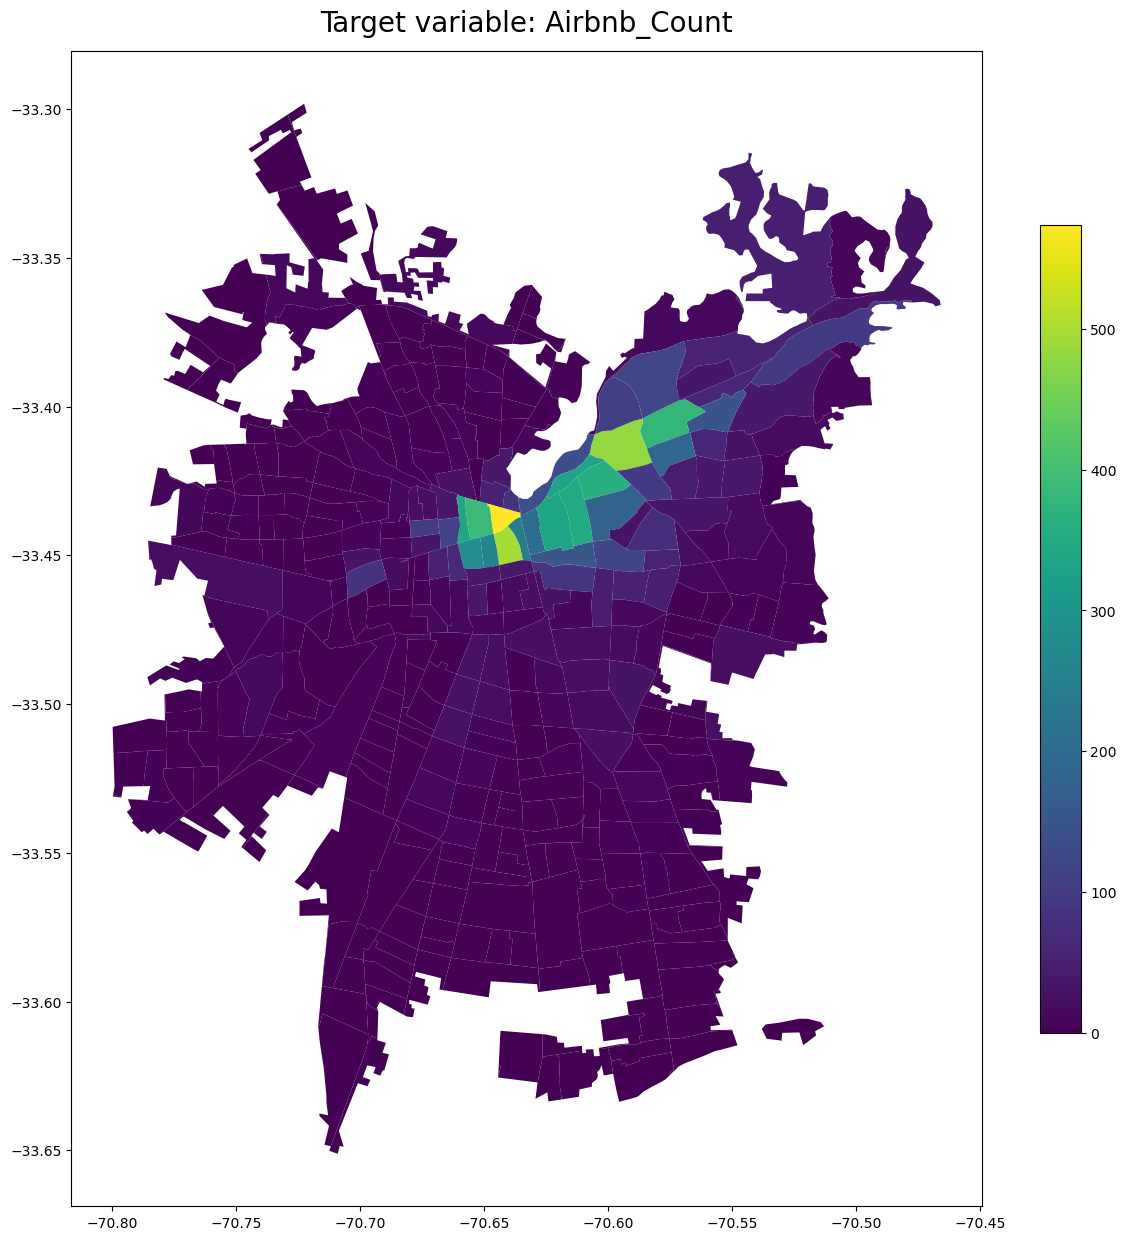

In [163]:
fig, ax = plt.subplots(figsize=(15, 15))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "target_variable.svg", format="svg")

plt.show()

# First model: All features

## Pipeline fit

In [164]:
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

## Sensitivity analysis

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


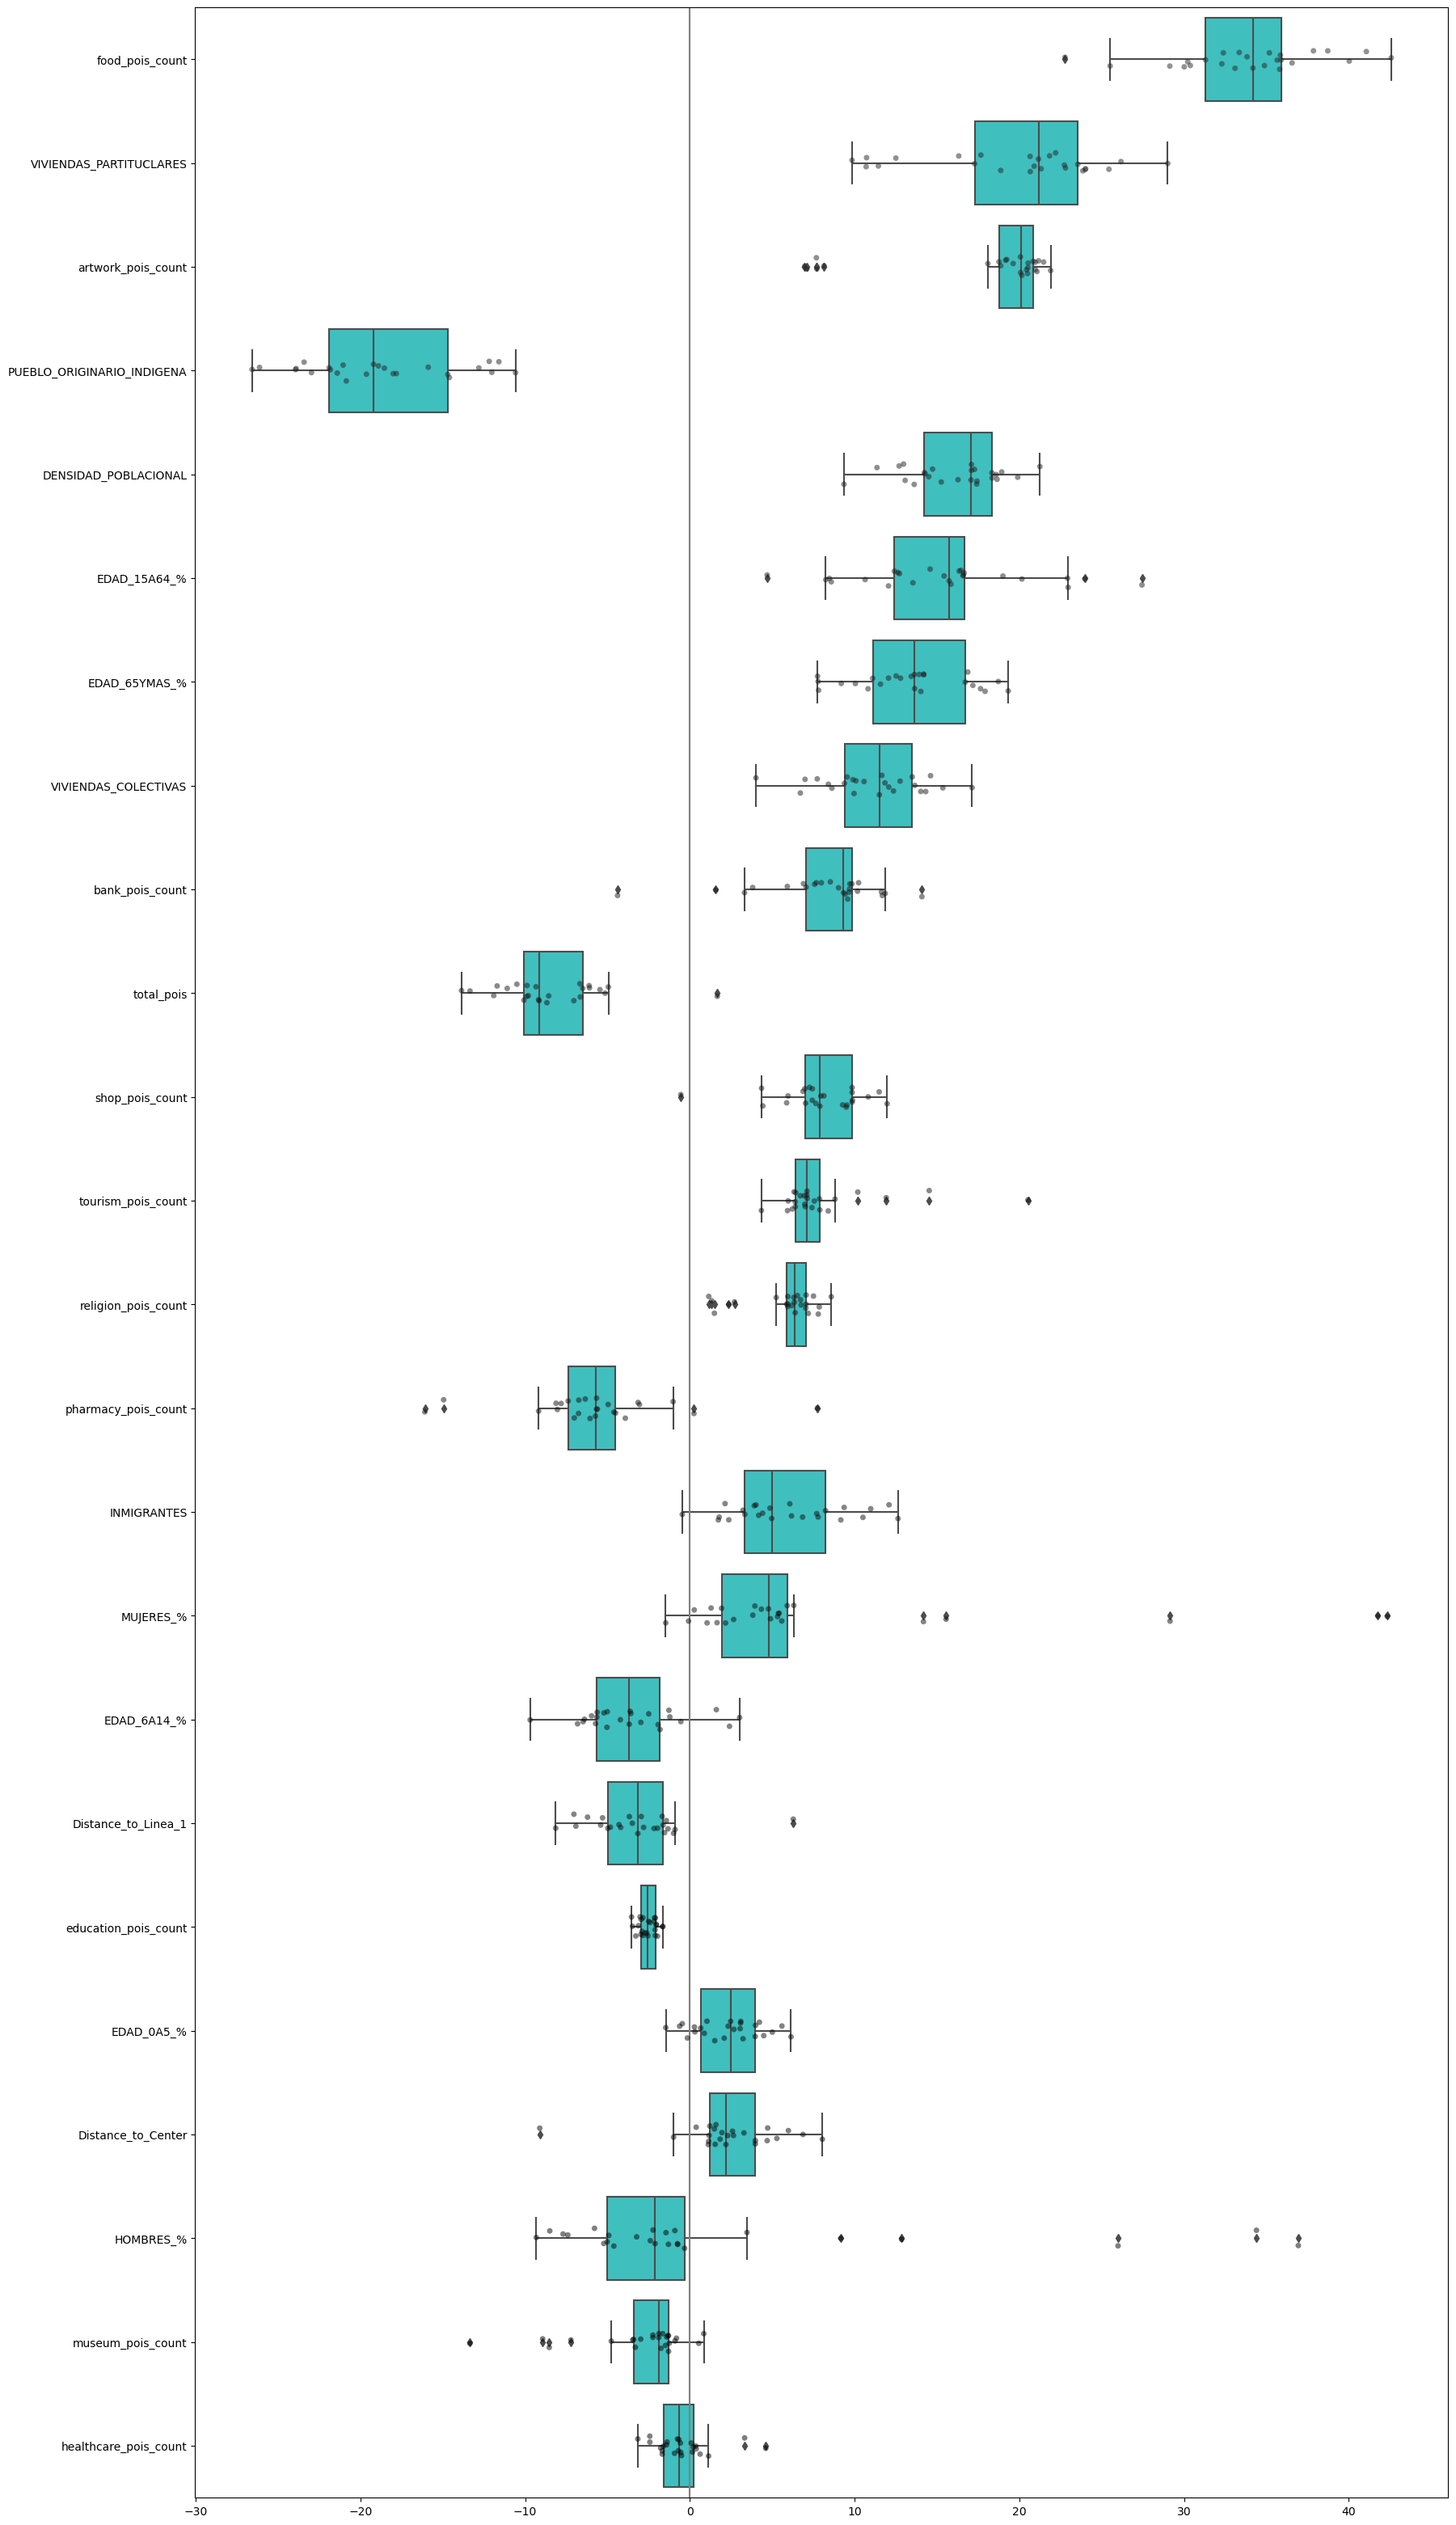

In [165]:
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "all_coefficients.svg", format="svg")

plt.show()

# Second model: Transformations and feature selection

## Normality tests

In [166]:
# Check which variables are already normal
normality_test = normaltests.get_normaltest_df(X.T)

print(normality_test["dagostino"].value_counts())
print(normality_test["shapiro"].value_counts())

dagostino
False    24
Name: count, dtype: int64
shapiro
False    24
Name: count, dtype: int64


## Preprocessing Pipeline

The preprocessing will have two phases:
* KNNImputer: To imput missing data by fitting knn (better than imputing the mean or the median)
* PowerTransformer: Since none of the features is Gaussian, we will transform them with the *Yeo-Johnson* transformation

In [167]:
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("pt", pt)])

## Feature Selection by Subgroups

In [168]:
selector = KBestSelector(
    score_func=f_regression, preprocessor=preprocessor, power_transformer=pt, y=y
)

In [169]:
X_Age = X.filter(regex="^EDAD")
X_Age_chosen = selector.k_best_selection(features=X_Age, k=X_Age.shape[1])

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [170]:
X_Pois = X.filter(regex="pois")
# print(X_Pois)
X_Pois_chosen = selector.k_best_selection(features=X_Pois, k=X_Pois.shape[1])

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [171]:
X_Viv = X.filter(regex="^VIV")
X_Viv_chosen = selector.k_best_selection(features=X_Viv, k=X_Viv.shape[1])

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [172]:
X.drop(np.setdiff1d(X_Age.columns, X_Age_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_Pois.columns, X_Pois_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_Viv.columns, X_Viv_chosen), axis=1, inplace=True)

# Feature Selection Pipeline    

In order to perform a feature selection, we will use *RFE* (Recursive Feature Elimination).

The number of variables to use will be a hyper-paramater that will be tuned with a GridSearch using RMSE as the metric.

The target feature will also be transformed with a PowerTransfomrer, by applying the *TransformedTargetRegressor*.

In [173]:
# X.loc[0, "Distance_Center"] = "hola"
# X['total_pois'] = X["total_pois"].astype(int)
int_columns = X.columns[~X.columns.str.contains("Distance")]
X[int_columns] = X[int_columns].astype(np.int32)
X.dtypes

INMIGRANTES                     int32
PUEBLO_ORIGINARIO_INDIGENA      int32
VIVIENDAS_PARTITUCLARES         int32
VIVIENDAS_COLECTIVAS            int32
MUJERES_%                       int32
HOMBRES_%                       int32
EDAD_0A5_%                      int32
EDAD_6A14_%                     int32
EDAD_15A64_%                    int32
EDAD_65YMAS_%                   int32
DENSIDAD_POBLACIONAL            int32
Distance_to_Center            float64
Distance_to_Linea_1           float64
religion_pois_count             int32
shop_pois_count                 int32
tourism_pois_count              int32
museum_pois_count               int32
total_pois                      int32
bank_pois_count                 int32
healthcare_pois_count           int32
food_pois_count                 int32
education_pois_count            int32
pharmacy_pois_count             int32
artwork_pois_count              int32
dtype: object

In [174]:
# Define the regressor to use
myRegressor = LinearRegression()

# Define a pipeline with the preprocessing, feature selection (RFE) and regressor
pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=myRegressor)),
        ("regressor", myRegressor),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(6, 15, 1)}]

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)


model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())

model.fit(X, y)

TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                             Pipeline(steps=[('imputer',
                                                                                              KNNImputer()),
                                                                                             ('pt',
                                                                                              PowerTransformer())])),
                                                                            ('rfe',
                                                                             RFE(estimator=LinearRegression())),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'rfe__n_features_to_select': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])}],
                                                  scoring='neg_root_mean_squared_error'),
                           transformer=PowerTransformer())

In [175]:
print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 6

List of features:
Index(['PUEBLO_ORIGINARIO_INDIGENA', 'VIVIENDAS_PARTITUCLARES',
       'VIVIENDAS_COLECTIVAS', 'DENSIDAD_POBLACIONAL', 'Distance_to_Center',
       'shop_pois_count'],
      dtype='object')


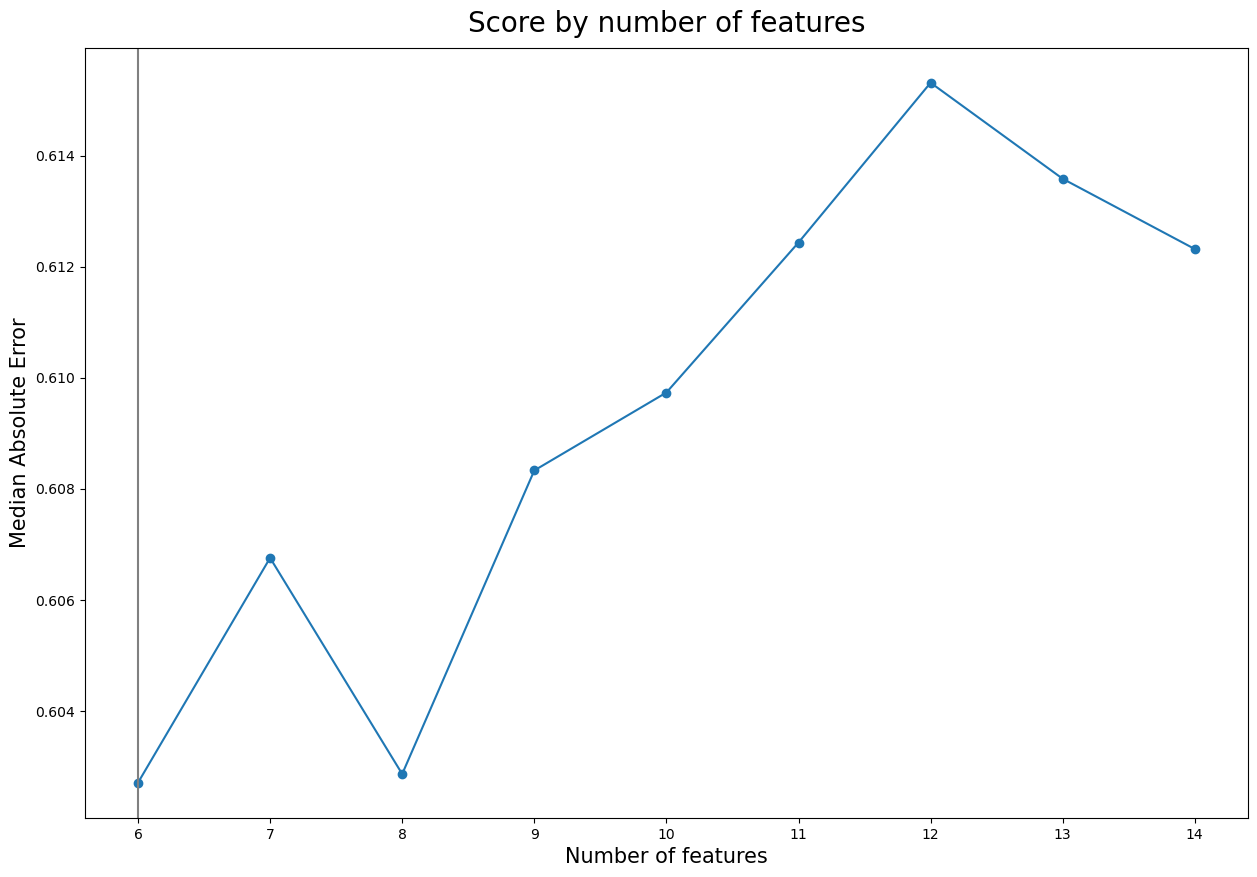

In [176]:
score_features = -model.regressor_.cv_results_["mean_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(n_features, score_features, marker="o")
plt.axvline(x=n_features[id_min_score], color=".5")

ax.set_xlabel("Number of features", fontsize=15)
ax.set_ylabel("Median Absolute Error", fontsize=15)
ax.set_xticks(np.arange(min(n_features), max(n_features) + 1))
ax.set_title("Score by number of features", fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "rmse.svg", format="svg")

plt.show()

In [177]:
y_pred_rfe = model.predict(X).round()
pa_rfe = PredictedAccuracy(y, np.nan_to_num(y_pred_rfe, nan=0))

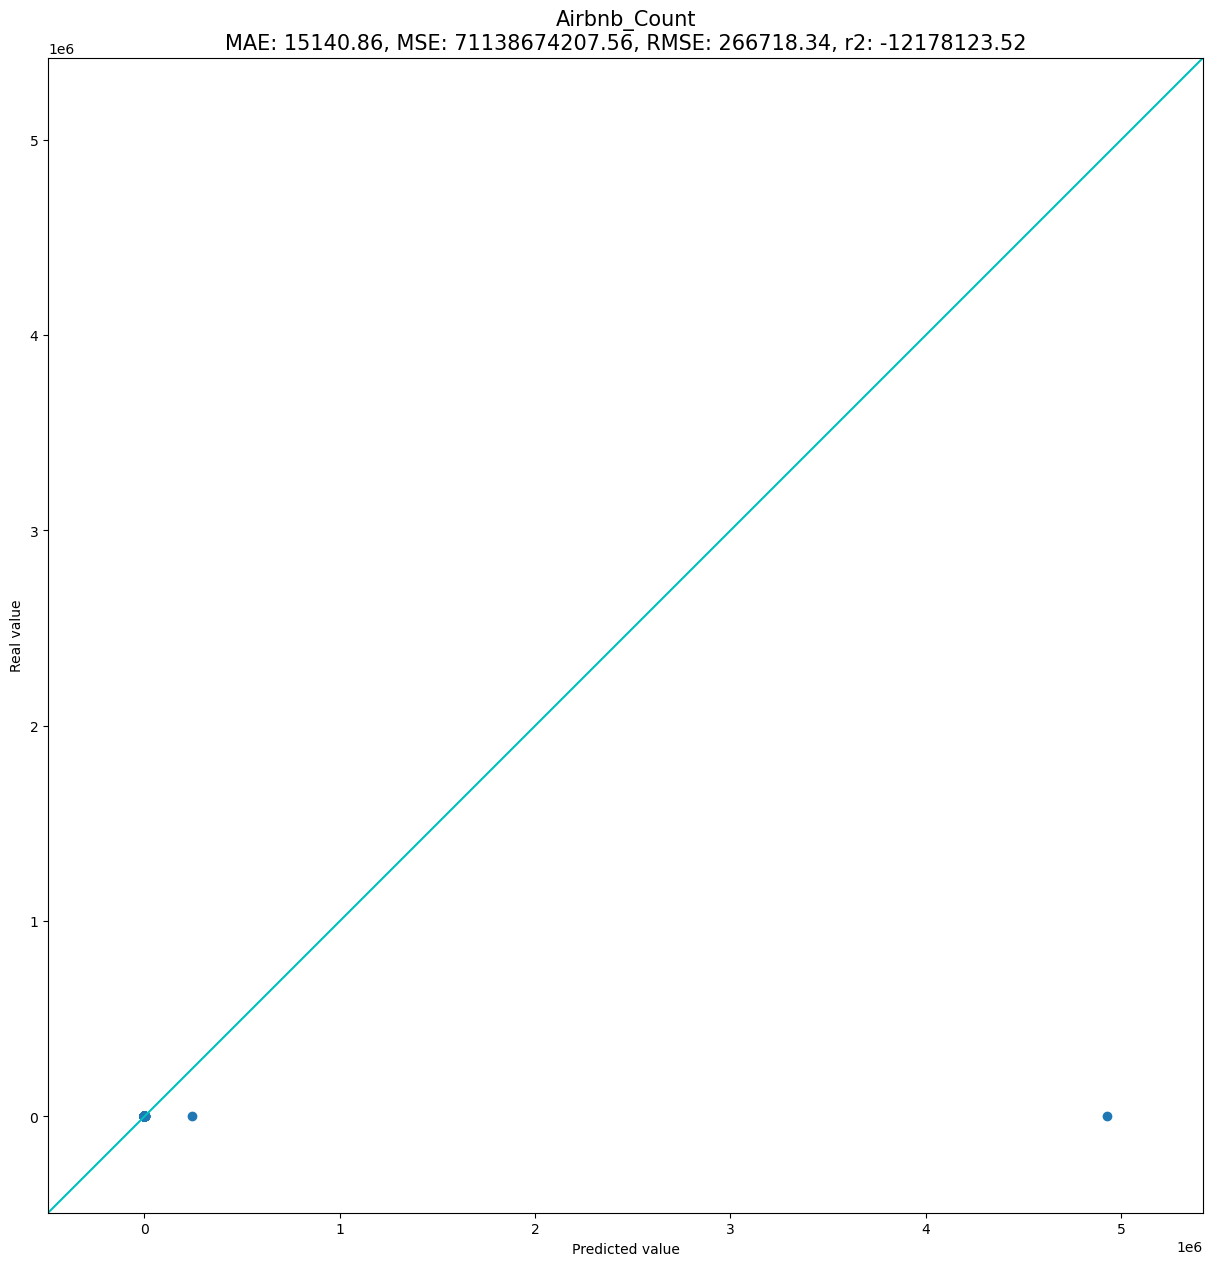

In [178]:
pa_rfe.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_LINEAR / "model")

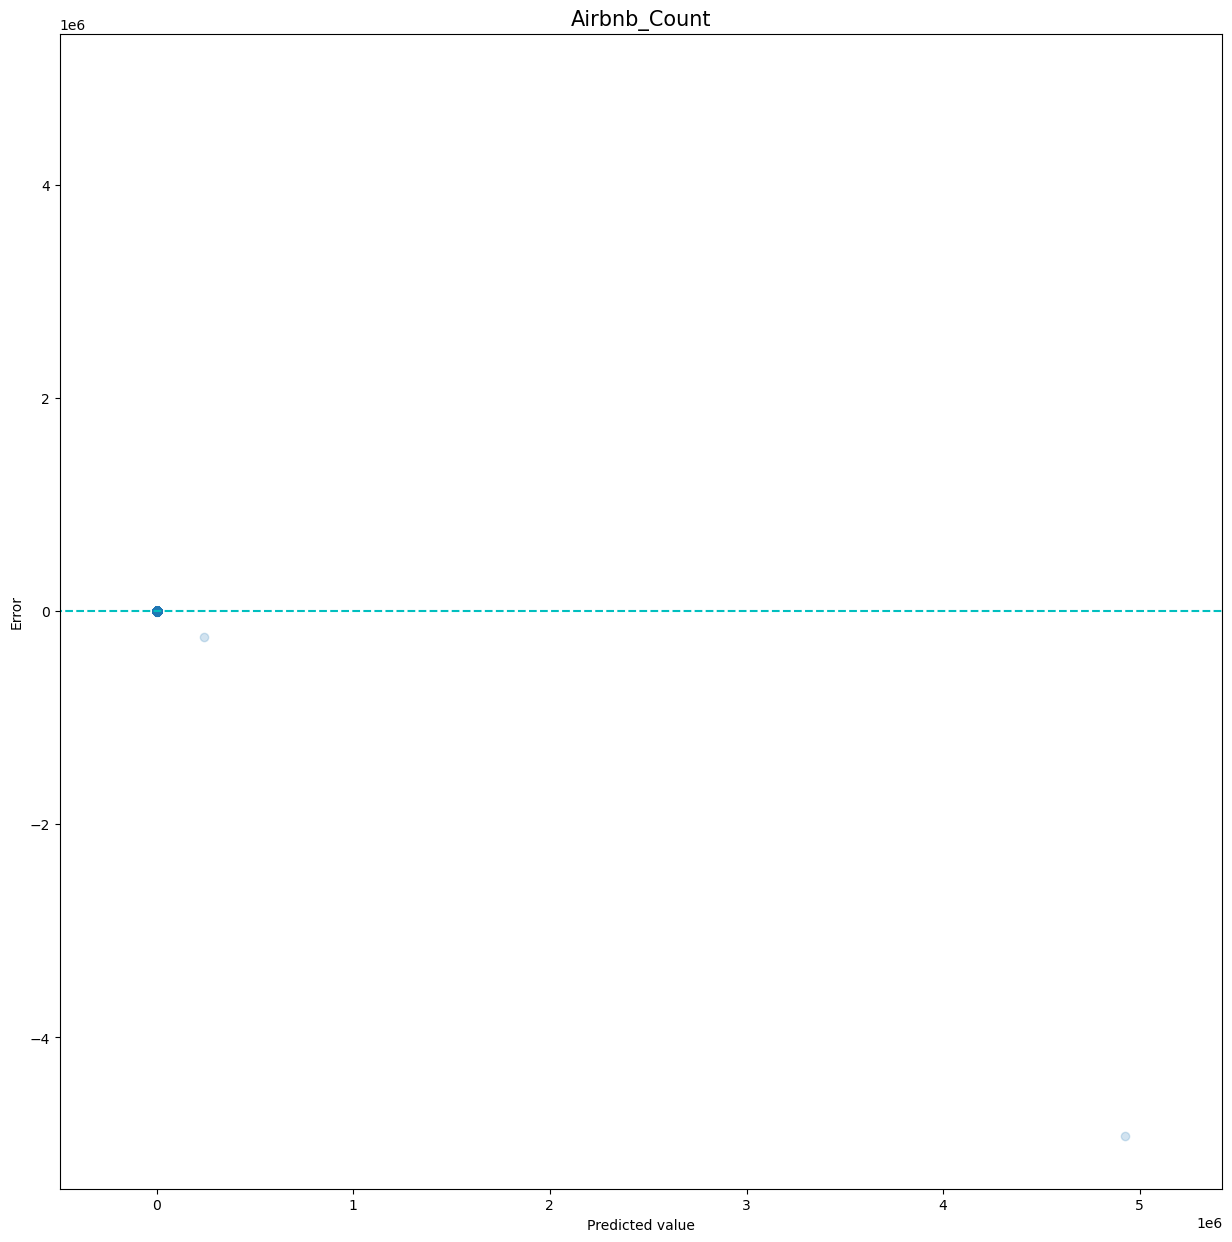

In [179]:
# pa_rfe.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_LINEAR / "model")
plt.close()
plt.figure(figsize=(15, 15))
x_max1 = pa_rfe.yhat_series.max()
x_min1 = pa_rfe.yhat_series.min()
y_max1 = pa_rfe.eps.max()
y_min1 = pa_rfe.eps.min()
x_max_min1 = x_max1 - x_min1
y_max_min1 = y_max1 - y_min1
x_padding1 = 0.1 * x_max_min1
y_padding1 = 0.1 * y_max_min1

axis_min1 = min(x_min1 - x_padding1, y_min1 - y_padding1)
axis_max1 = max(x_max1 + x_padding1, y_max1 + y_padding1)

plt.rcParams["axes.grid"] = False

plt.scatter(pa_rfe.yhat_series, pa_rfe.eps, alpha=0.2)
plt.plot(
    [axis_min1, axis_max1],
    [0, 0],
    "c--",
)

plt.xlim([x_min1 - x_padding1, x_max1 + x_padding1])
plt.ylim([-axis_max1, axis_max1])
plt.xlabel("Predicted value")
plt.ylabel("Error")
plt.title(pa_rfe.y_series.name, fontsize=15)

# if save_fig is True:
#     plt.savefig(str(root_name) + "1.svg", format="svg")

plt.show()

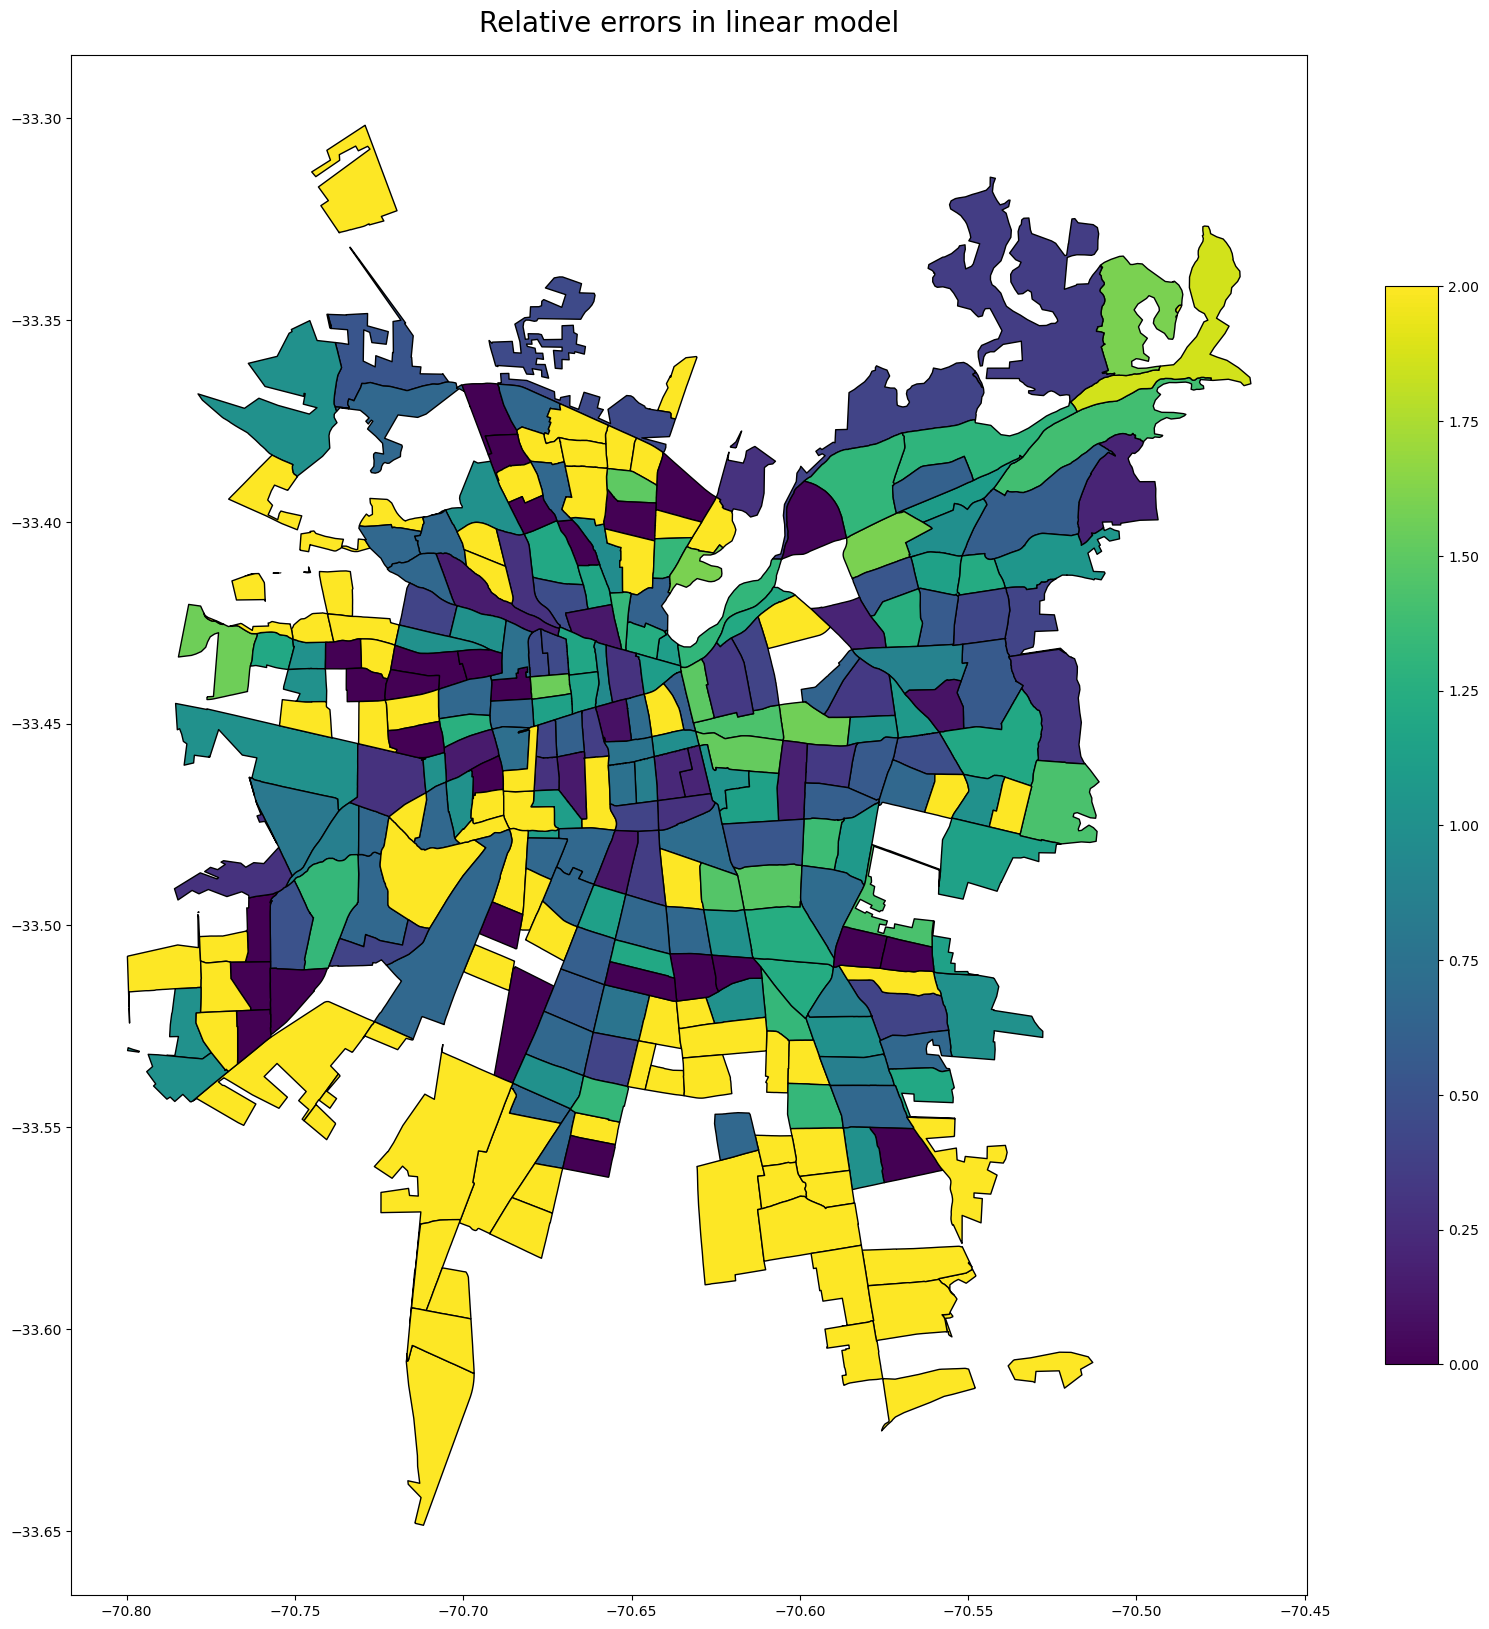

In [180]:
geo_info["Chosen_Error"] = np.abs(2 * (y - y_pred_rfe) / (abs(y) + abs(y_pred_rfe)))

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    figsize=(20, 20),
    edgecolor="black",
    cmap="viridis",
    vmin=0,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)


if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "relative_errors.svg", format="svg")

plt.show()

In [181]:
if SAVE_MODEL is True:
    geo_info[["Chosen_Error"]].to_csv(DIR_LINEAR / "relative_errors.csv")
    pd.DataFrame(y_pred_rfe, index=geo_info.index, columns=["Predictions"]).to_csv(
        DIR_LINEAR / "predictions.csv"
    )

In [182]:
pw = PowerTransformer()
pw.fit(y.values.reshape(-1, 1))

####################Tranform y_hat####################
y_pred_transformed = np.nan_to_num(model.predict(X), 0)
y_pred_transformed = pw.transform(y_pred_transformed.reshape(-1, 1)).flatten()

####################Trasform y####################
# y_test_transformed = pd.Series(pw.transform(y_test.values.reshape(-1, 1)).flatten())
y_transformed = pd.Series(pw.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed Airbnb_Number"

# print(y_pred_transformed)


pa_rfe = PredictedAccuracy(y_transformed, y_pred_transformed)

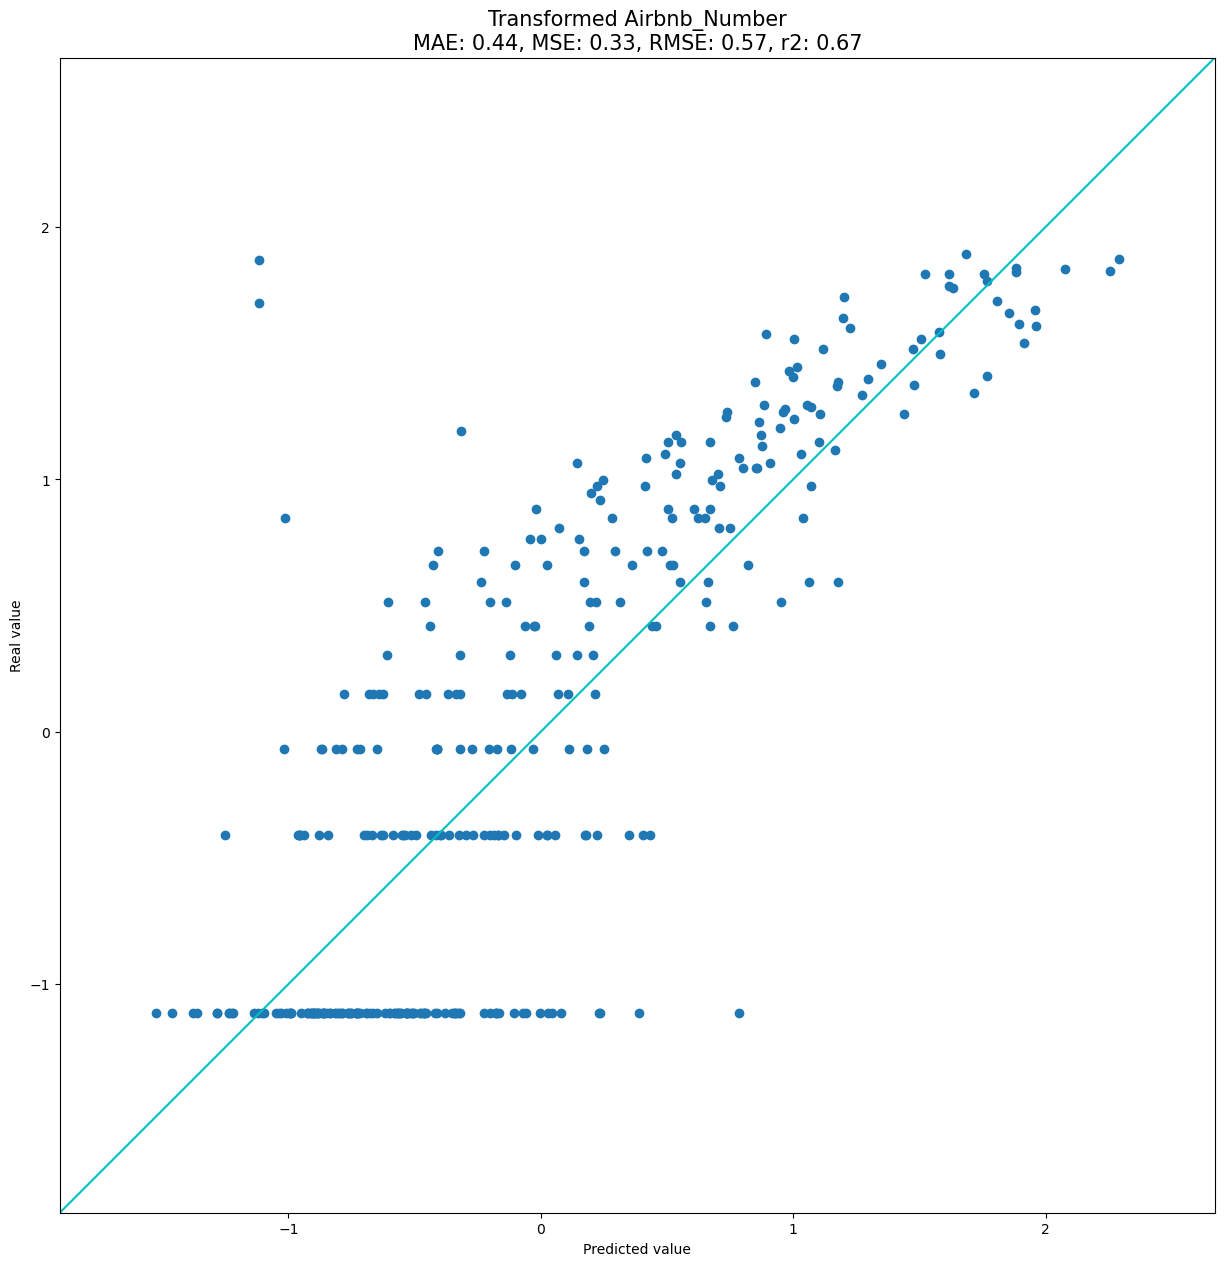

In [183]:
pa_rfe.plot_scatter(
    save_fig=SAVE_FIGS,
    root_name=DIR_LINEAR / "transformed_model",
)

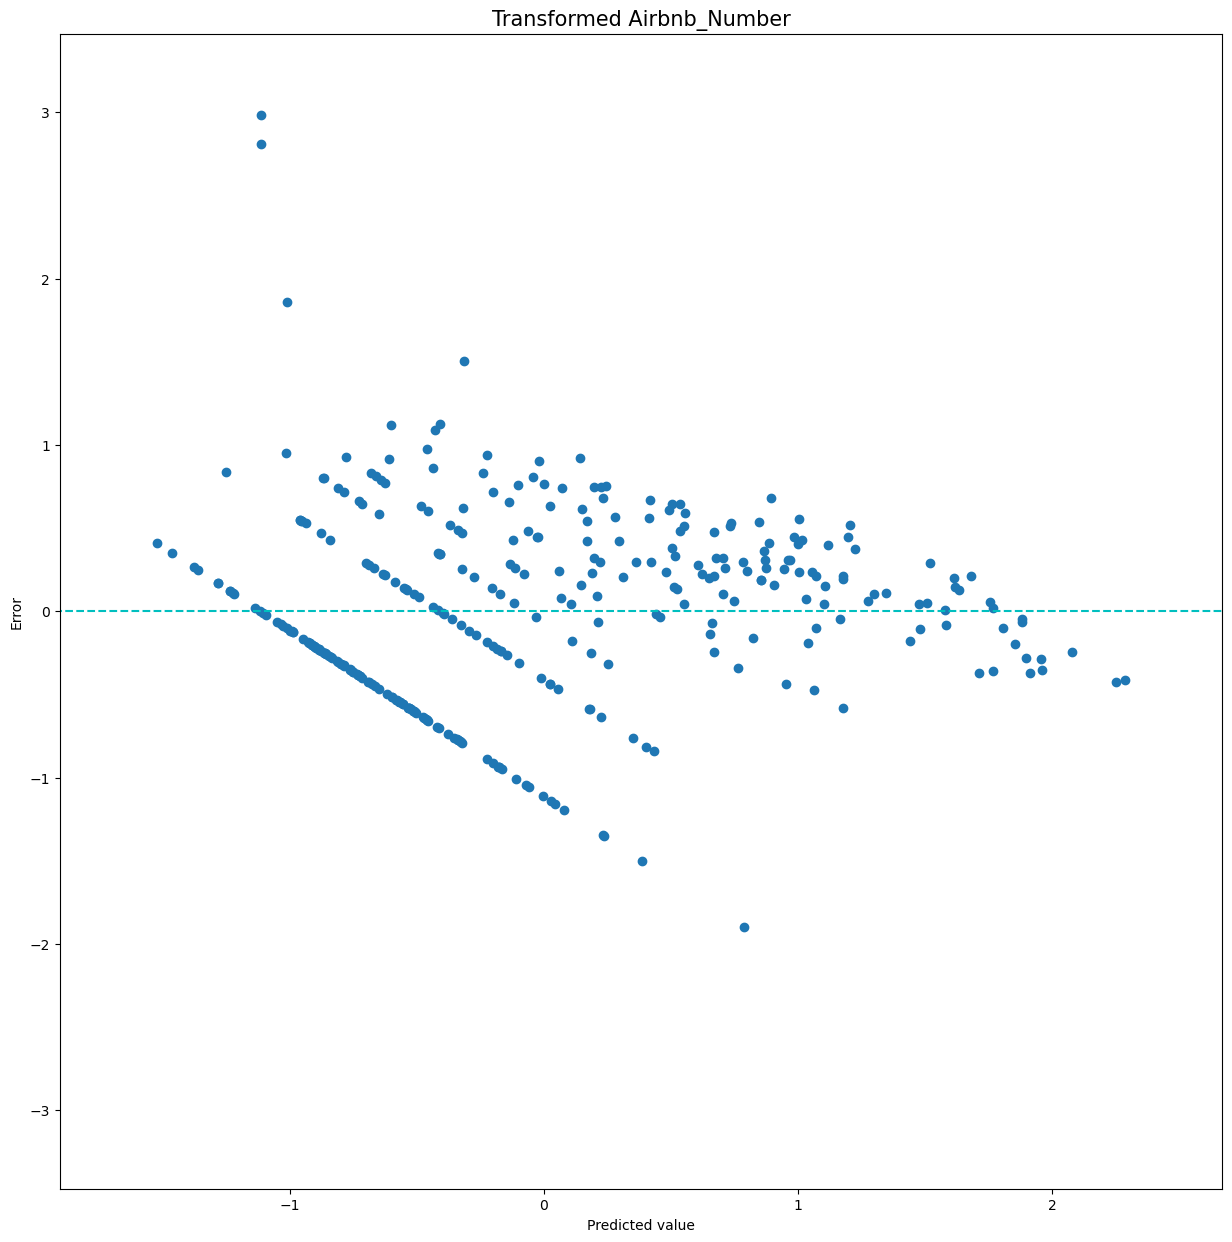

In [184]:
pa_rfe.plot_errors(
    save_fig=SAVE_FIGS,
    root_name=DIR_LINEAR / "transformed_model",
)

# Sensitivity Analysis

In [185]:
X_rfe = X.iloc[:, cols_rfe]

pipe_sens = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", myRegressor)])

model_sens = TransformedTargetRegressor(
    regressor=pipe_sens, transformer=PowerTransformer()
)

model_sens.fit(X_rfe, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('imputer',
                                                                       KNNImputer()),
                                                                      ('pt',
                                                                       PowerTransformer())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

In [186]:
cv_rfe = cross_validate(
    model_sens,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

coefs_rfe["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_rfe["estimator"]]
)

medians_rfe = coefs_rfe.drop(["Intercept"], axis=1).median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
medians_rfe = pd.concat(
    [medians_rfe, pd.Series({"Intercept": None}, index=["Intercept"])]
)
coefs_rfe = coefs_rfe[medians_rfe.index]

limit_value = (
    max(abs(coefs_rfe.to_numpy().min()), abs(coefs_rfe.to_numpy().max())) * 1.05
)

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/sklearn/metrics/_regression

/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/flac/miniconda3/envs/urbana/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


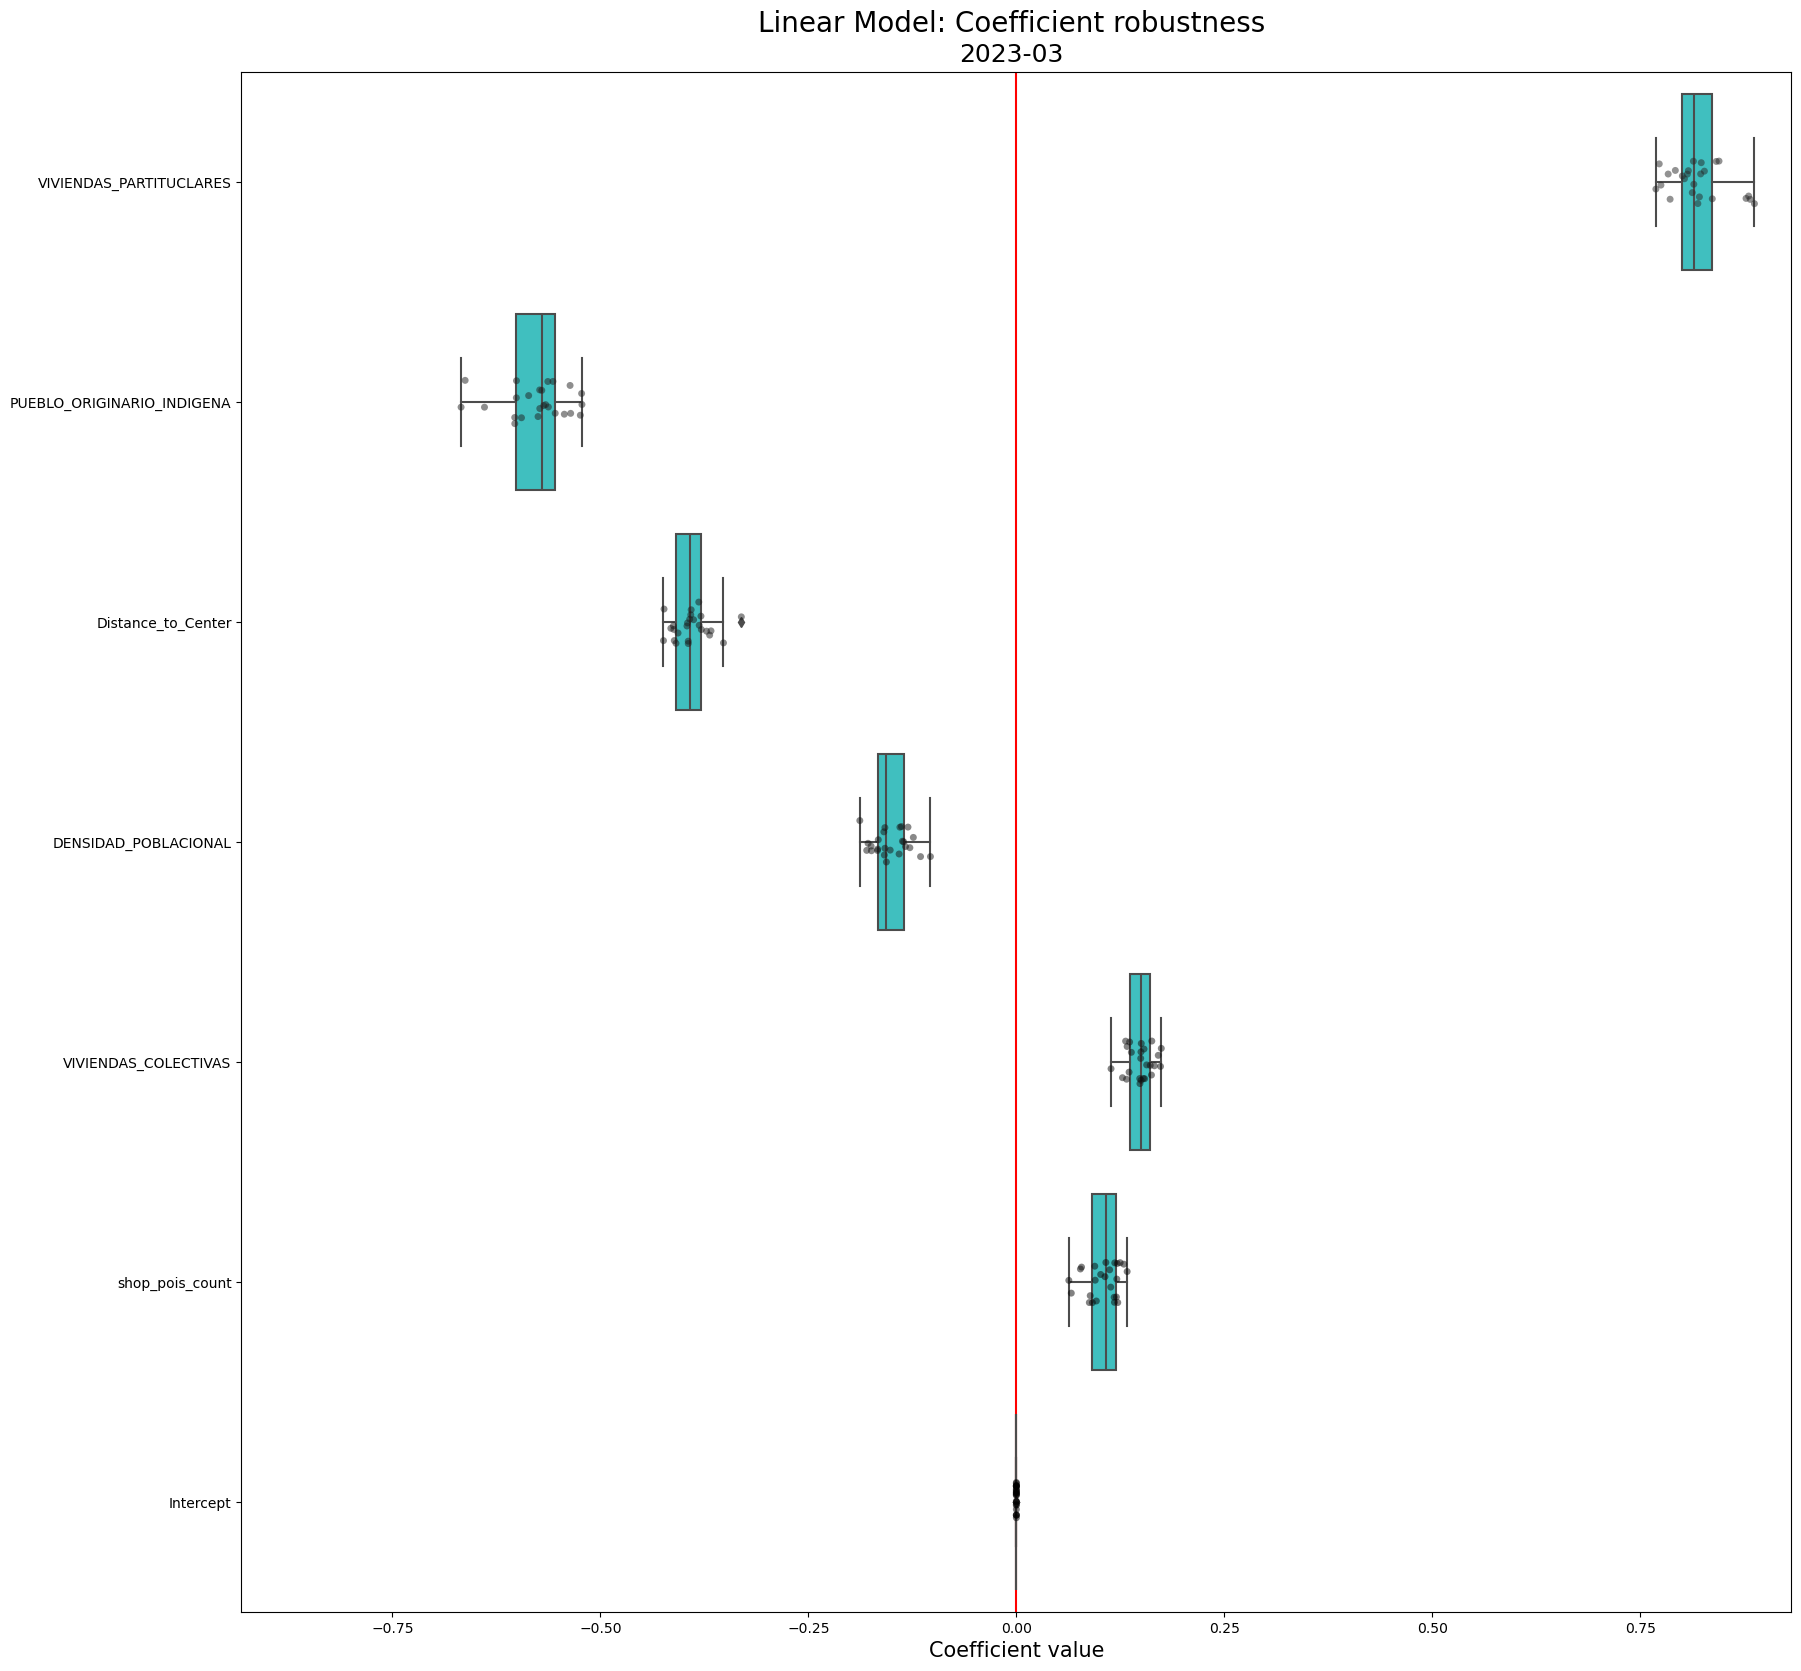

In [187]:
YEAR, MONTH = 2023, 3

fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(ax=ax, data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax, data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")

plt.figtext(0.51, 0.9, "Linear Model: Coefficient robustness", fontsize=20, ha="center")
plt.figtext(
    0.51,
    0.885,
    "{}-{:02d}".format(YEAR, MONTH),
    fontsize=18,
    ha="center",
)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "sensitivity.svg", format="svg")

plt.show()

In [188]:
if SAVE_MODEL is True:
    coefs_rfe.to_csv(DIR_LINEAR / "coefficients.csv")
    coefs_rfe.to_csv(
        DIR_VAR / "01_linear/coefficients_{}_{:02d}.csv".format(YEAR, MONTH)
    )